# MFE 230P: ASSIGNMENT III
**SUGGESTED SOLUTION** \\ Mustafa S Eisa

# 1. Feature Engineering & Kernalization

### A. Feature Design

Executing the cell below will create a pandas dataframe `data` containing 2015-16 daily adjusted percent returns for the top 99 US companies by market cap (as of 31 December 2016).

In [1]:
import pandas as pd

data = pd.read_csv(
    '../../data/top_99_returns.csv',
    header=0,
    index_col=0
)

data.head()

,AAPL,MSFT,XOM,AMZN,JNJ,JPM,GE,WFC,FB,GOOG,...,MET,EOG,CL,NVDA,PNC,EPD,VOO,ABT,SPG,NEE
date,,,,,,,,,,,,,,,,,,,,,
20150102,-0.009513,0.006674,0.004110,-0.005897,-0.000478,-0.001438,-0.008310,-0.002189,0.005511,-0.003021,...,-0.003328,0.001846,-0.002168,0.003990,-0.004494,0.019657,0.000000,-0.002665,0.017737,0.003763
20150105,-0.028172,-0.009303,-0.027362,-0.020517,-0.006984,-0.031045,-0.018356,-0.027422,-0.016061,-0.020846,...,-0.033389,-0.060278,-0.007387,-0.016890,-0.030610,-0.065979,-0.017569,0.000223,0.004101,-0.010591
20150106,0.000094,-0.014571,-0.005316,-0.022833,-0.004914,-0.025929,-0.021545,-0.020865,-0.013473,-0.023177,...,-0.030321,-0.028496,-0.010506,-0.030318,-0.025897,-0.023547,-0.009833,-0.011356,0.027834,0.003884
20150107,0.014022,0.012705,0.010133,0.010600,0.022076,0.001526,0.000415,0.005951,0.000000,-0.001713,...,0.013259,-0.006294,0.007963,-0.002866,0.011544,0.012801,0.012495,0.008108,0.018402,0.009154
20150108,0.038422,0.029418,0.016645,0.006836,0.007863,0.022346,0.012043,0.022137,0.026592,0.003153,...,0.015234,0.038241,0.013606,0.037889,0.019251,0.012346,0.017568,0.020554,-0.001437,0.006078


Engineer a few features (5-10) that, in your judgement, would be effective in characterizing the daily equity returns of each company. For example, $\left|\frac{\max}{\min}\right|$ return or average squared return—be creative and use your instincts. Then, project the asset returns `data` into to this new feature space by creating a new matrix `data_fe` where each row represents a feature you engineered and each column represents a company. (Note that, unlike in previous assignments, the columns now represent observations while the rows represent features.)

Center and scale each row of `data` and `data_fe` (you may design your own center and scaling protocol or stick with simple mean and standard deviation). Intuitively ration why we perform this standardization.

### SOLUTION.

For each company returns series $\{r_t\}_{t=1}^T$, where $T$ is the total number of dates recorded in `data`, we first transform to log-returns $\{x_t\}_{t=1}^T$ where

$$x_t = \log\left(1 + r_t\right)$$

Then, we engineer the following features.

1. Mean Log-Return: $\bar{x} = \frac{1}{T}\sum_{t=1}^T x_t$
2. Square Root Volatility: $\sigma = \sqrt{\frac{1}{T-1}\sum_{t=1}^T (x_t - \bar{x})^2 }$
3. Sample Skewness:
$$s = \frac{\frac{1}{T}\sum_{t=1}^T (x_t - \bar{x})^3}{\sigma^3}$$
4. Sample Kurtosis:
$$\kappa = \frac{\frac{1}{T}\sum_{t=1}^T (x_t - \bar{x})^4}{\sigma^4}$$
5. Square Root Lower Semi-Volatility: $$\sigma_- = \sqrt{\frac{1}{|\Omega_-| -1}\sum_{t\in\Omega_-} (x_t - \bar{x})^2 }$$ 
6. Log Ratio of Max to Min Cumulative Return:
$$z = \max_T \left\{\sum_{t=1}^T x_t\right\} - \min_T \left\{\sum_{t=1}^T x_t\right\}$$

so that each company's returns series $\{r_t\}_{t=1}^T$ (which is a row of dimension $T$ in `data`) is mapped via $\phi: \mathbb{R}^T \mapsto \mathbb{R}^6$ as

$$\phi\left(r_1, \dots, r_T\right) = \left(\bar{x}, \sigma, s, \kappa, \sigma_-, z\right)$$

We normalize each column so that the features are on the same scale. In other words, the normalization allows us to compute a simple distance between two companies where all features contribute (roughly) equally to the calculated distance. Otherwise, one feature that is on a much larger scale may contributed much more to the distance calculation making it so that we are essentially not taking into account the variation occurring in other dimensions. The centering does the same, allowing us to compare values to their deviation from the center rather than a raw value which again bias calculations like distance.

Now we will construct the feature mapping $\phi$,

In [2]:
import numpy as np
from scipy.stats import skew, kurtosis

def phi(returns):
    """
    Takes a flat numpy array returns, outputs the six features provided above.
    """
    x = np.log(1 + returns)
    
    xbar = x.mean()
    sigma = x.std()
    s = skew(x)
    kappa = kurtosis(x)
    
    mask = (x < xbar)
    omega_ = mask.sum()
    sigma_ = np.sqrt(
        (1/omega_) * ((x[mask] - xbar)**2).sum()
    )

    z = x.cumsum().max() - x.cumsum().min()

    return (xbar, sigma, s, kappa, sigma_, z)

and apply it to `data` to produce `data_fe`.

In [3]:
data_fe = pd.DataFrame(
    [phi(data[company]) for company in data.columns]
).T

data_fe.columns = data.columns
data_fe.index = ['mean', 'vol', 'skew', 'kurtosis', 'semivol', 'logratio']

data_fe

,AAPL,MSFT,XOM,AMZN,JNJ,JPM,GE,WFC,FB,GOOG,...,MET,EOG,CL,NVDA,PNC,EPD,VOO,ABT,SPG,NEE
mean,0.000095,0.000577,-0.000048,0.001750,0.000192,0.000637,0.000444,0.000010,0.000771,0.000765,...,-0.000007,0.000186,-0.000111,0.003318,0.000493,-0.000574,0.000171,-0.000315,-0.000049,0.000232
vol,0.015817,0.016074,0.013268,0.019681,0.009490,0.014816,0.012419,0.013849,0.016857,0.015611,...,0.018251,0.021857,0.010598,0.024902,0.013739,0.021957,0.009066,0.014627,0.012261,0.011652
skew,-0.170609,0.240441,0.156305,1.294038,0.271322,0.019365,1.177178,0.263536,1.021112,1.879108,...,-0.796973,0.222397,-0.209002,2.850316,-0.222526,0.142673,-0.312582,-1.379712,-0.714800,-0.407290
kurtosis,2.501773,8.712857,2.136818,9.831970,2.859491,3.515708,9.939287,2.505405,11.139578,17.782739,...,5.490966,1.721803,3.941370,26.030049,1.747456,2.670698,2.317891,6.932344,1.400685,2.760771
semivol,0.016084,0.015601,0.013037,0.017221,0.009315,0.014736,0.011417,0.013608,0.016228,0.013806,...,0.019343,0.020760,0.011158,0.020157,0.013938,0.022040,0.009199,0.016654,0.014107,0.012601
logratio,0.386775,0.456820,0.325252,1.079266,0.323617,0.495783,0.347220,0.290871,0.587703,0.503998,...,0.493920,0.583892,0.220589,1.813391,0.418138,0.621137,0.221068,0.342818,0.285927,0.324485


Finally, we will center and scale both datasets by median and mean absolute deviation.

In [4]:
data_fe = data_fe.T

data_fe -= data_fe.median(axis=0)
data_fe /= np.sqrt(2/np.pi) * (1/data_fe.shape[0]) * np.linalg.norm(data_fe, 1, axis=0)

data_fe = data_fe.T

data = data.T

data -= data.median(axis=0)
data /= np.sqrt(2/np.pi) * (1/data.shape[0]) * np.linalg.norm(data, 1, axis=0)

data = data.T

### B. Visualize Data

Project data to 2D space using a method your choice so that the data can be visualized. Two recommended options include [Multi-Dimensional Scaling](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

You do not need to understand what these lower-dimensional embedding algorithms do, just apply them and then plot the data in 2D. When displaying the points in 2D, plot the ticker of each company rather than a point so that the tickers are laid out on the 2D Cartesian plan. Do this for both `data` and `data_fe`.

How does the raw data approach compare to your feature-mapping? Are the companies displayed in a way that respects your feature mapping? Briefly comment.

### SOLUTION.

First we set up the multi-dimensional scaling function

In [5]:
from sklearn.manifold import MDS

dimRed = MDS(
    n_components=2,
    max_iter=500,
    n_init=20
)

And then map both `data` and `data_fe` to 2D and plot the results.

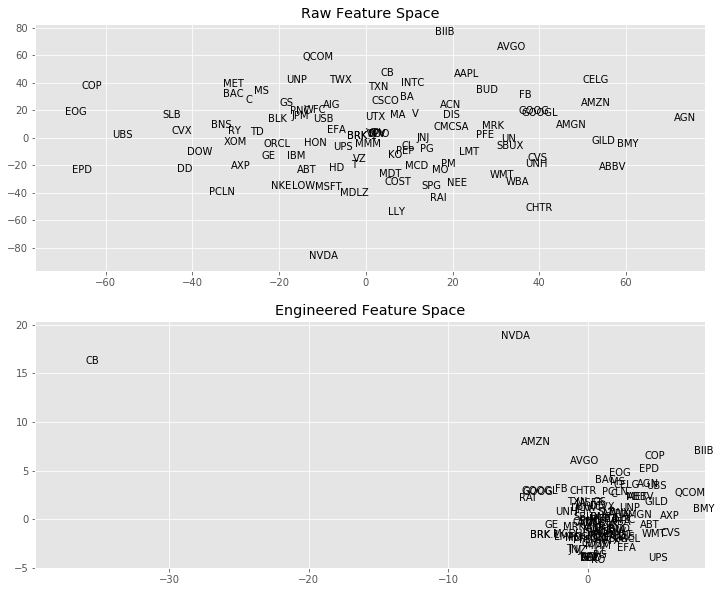

In [6]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.figure(figsize=(12, 10))

ax = plt.subplot(2,1,1)

dimRed.fit(
    data.as_matrix().T
)

ax.set_ylim((1.1*dimRed.embedding_[:,1].min(), 1.1*dimRed.embedding_[:,1].max()))
ax.set_xlim((1.1*dimRed.embedding_[:,0].min(), 1.1*dimRed.embedding_[:,0].max()))
ax.set_title('Raw Feature Space')

for i in range(dimRed.embedding_.shape[0]):
    plt.annotate(
        s=data.columns[i],
        xy=dimRed.embedding_[i]
    )

ax = plt.subplot(2,1,2)

dimRed.fit(
    data_fe.as_matrix().T
)

ax.set_ylim((1.1*dimRed.embedding_[:,1].min(), 1.1*dimRed.embedding_[:,1].max()))
ax.set_xlim((1.1*dimRed.embedding_[:,0].min(), 1.1*dimRed.embedding_[:,0].max()))
ax.set_title('Engineered Feature Space')

for i in range(dimRed.embedding_.shape[0]):
    plt.annotate(
        s=data_fe.columns[i],
        xy=dimRed.embedding_[i]
    )

plt.show()

The feature mapped space seems to distinguish certain tickers much more seriously than the raw data approach, in which differences seem less exaaggurated. Indeed, the plot respects the feature mapping; for example, `AMZN` has a very large mean return compared to other companies while `NVDA` has high mean, high kurtosis, and high positive skew, explaining why it is significantly farther than `AMZN` from the rest of the companeis.

### C. Kernelized Feature Space

Create two square kernel matrices `kernel` and `kernel_fe` by applying a Gaussian kernel transformation to both the raw returns in `data` as well as their projection into your feature space, represented in `data_fe`. Then, use PCA to make a 10-dimensional approximation of the kernel matrix before continuing with MDS, t-SNE, or some other choice of low-dimensional embedding method to further reduce everything to 2D coordinates. Then, plot the results.

You will need to play with $\gamma$ parameter defining the Gaussian kernel to get results that look interesting. Compare the two plots as you did in the previous part.

### SOLUTION.

First, we define the function that creates a kernel matrix and then uses PCA to create a 10-dimensional approximation.

In [7]:
def kernel_matrix(X, gamma=1):
    """Creates low-dim kernel matrix from X where rows are features, columns are obs."""
    
    p, n = X.shape
    K = np.eye(n, n) # diagonal must be ones
    
    for i in range(n):
        for j in range(i):
            K[i, j] = np.exp(
                -gamma*np.linalg.norm(
                    X[:, j] - X[:, i]
                )**2
            )

    upper_triangular_indices = np.triu_indices_from(K, 1)
    K[upper_triangular_indices] = K.T[upper_triangular_indices]
    
    D, P = np.linalg.eig(K)

    return P.dot(np.diag(D)).dot(P.T[:,:10])

Then we produce the graphics.

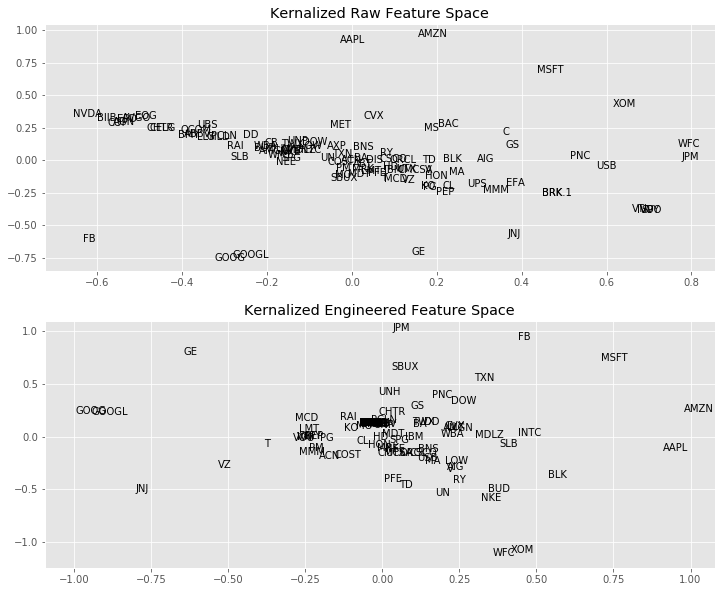

In [8]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(12, 10))

ax = plt.subplot(2,1,1)

dimRed.fit(kernel_matrix(data.as_matrix(), gamma=5e-4))

ax.set_ylim((1.1*dimRed.embedding_[:,1].min(), 1.1*dimRed.embedding_[:,1].max()))
ax.set_xlim((1.1*dimRed.embedding_[:,0].min(), 1.1*dimRed.embedding_[:,0].max()))
ax.set_title('Kernalized Raw Feature Space')

for i in range(dimRed.embedding_.shape[0]):
    plt.annotate(
        s=data.columns[i],
        xy=dimRed.embedding_[i]
    )

ax = plt.subplot(2,1,2)

dimRed.fit(kernel_matrix(data_fe.as_matrix(), gamma=.5))

ax.set_ylim((1.1*dimRed.embedding_[:,1].min(), 1.1*dimRed.embedding_[:,1].max()))
ax.set_xlim((1.1*dimRed.embedding_[:,0].min(), 1.1*dimRed.embedding_[:,0].max()))
ax.set_title('Kernalized Engineered Feature Space')

for i in range(dimRed.embedding_.shape[0]):
    plt.annotate(
        s=data_fe.columns[i],
        xy=dimRed.embedding_[i]
    )

plt.show()

In this example, we can see that kernelazation significantly improves the raw data plot, putting together companies that appear to experience similar returns. The kernalized version of the engineered features does not look that much different, however, from the previous part.

### D. Interpreting the Results

In light of the previous analysis, what are the advantages and disadvantages of using engineered features in place of the raw data? What role does kernalization play? Briefly comment.

### SOLUTION.

Engineering features allows the user to augment what is already avaiable with additional features of interest. Doing so allows us to achieve more relevant results to the machine learning task at hand later in the modeling stages. Kernalization allows the user to capture non-linear, non-parametric structures that are present in the feature space, allowing for richer and more flexible modeling.

# 2. Least Squares and Quantile Regression

### A. LAD Regression is a Linear Program

Show that LAD regression can be written as a linear program. What does this mean computationally as compared to the equivalent problem in which $\ell_1$ replaced with $\ell_2$?

### SOLUTION.

Start by writing the unconstrained LAD problem as

$$\min_{\theta} \|\epsilon\|_1$$

where $\epsilon = y - X\theta$. By definition,

$$\|\epsilon\|_1 = \sum_{i} | \epsilon_i | = \sum_{i} \max\{\epsilon_i, -\epsilon_i \}$$

Therefore, we may introduce slack variables $s_i$ and write

$$\min_{\theta, s_i} \sum_i s_i \text{ subject to } s_i \geq \epsilon_i, \ s_i \geq  -\epsilon_i$$

since $s_i \geq  \max\{\epsilon_i, -\epsilon_i \}$ if and only if $s_i \geq \epsilon_i$ and $s_i \geq -\epsilon_i$. Since $\epsilon_i$ is affine in $\theta$ and all constraints and the objective are affine in $s_i$, this is a linear program. Note that because we are optimizing over $s_i$ as well as $\theta$, we should expect $s_i$ to be as small as possible while abiding by the constraints we set. In other words, we should expect $s_i=|\epsilon_i|$ at optimum. Similarly, we are optimizing over $\theta$ to make $|\epsilon_i|$ and therefore $s_i$ as small as possible.

Since linear programs are subsets of quadratic programs, we should expect this to be a relatively less computationally intensive problem to solve.

### B. Adaptive Index Quantiles with Least Squares

Executing the cell below will create a pandas dataframe `X` containing 2014-16 daily adjusted percent returns for the top (roughly) 500 US companies by market cap (as of 31 December 2016) and another pandas dataframe `y` containing daily adjusted returns for the `SPY` ETF over the same period, which tracks the S&P 500 index closely.

In [9]:
X = pd.read_csv(
    '../../data/top_500_returns.csv',
    header=0,
    index_col=0
)

y = pd.read_csv(
    '../../data/spy.csv',
    header=0,
    index_col=0
)

Tranform the data to log returns. Then, split the data into training and validation sets, where the first 60% of dates constitute the former.  Using only `cvxpy` and `numpy`, perform [least-norm regression](https://see.stanford.edu/materials/lsoeldsee263/08-min-norm.pdf) on the training set, regressing `SPY`'s return on the lagged returns of the top 500 companies:

$$\min_{\theta} \|\theta\|_2 \text{ subject to } y_t = \alpha + X_{t-1}\theta$$

where $\alpha$ is an intercept term. Plot your model's predictions on the training and validation set _cumulative returns_ along with a histogram of your model's residuals on the validation set. Briefly comment on what you see. Does the residual distribution appear to be Gaussian? Check your hypothesis using a statistical test such as [Shapiro-Wilks](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.shapiro.html).

One way to forecast the 1-step-ahead 90th percentile of index returns for `SPY` using lagged returns of the top 500 companies is to follow steps similar to those outlined in [this stack exchange post](https://stats.stackexchange.com/questions/147242/how-to-calculate-the-prediction-interval-for-an-ols-multiple-regression). Comment on the potential effectiveness of this method in light of the out-of-sample residual distribution you previously analyzed.

### SOLUTION.

First we'll split the data into training and validation sets and lag $X$ one period behind $y$.

In [10]:
from math import floor

n, p = X.shape

X = np.log(1 + X.as_matrix())
y = np.log(1 + y.as_matrix())

Xtrain = X[:floor(.6*n)-1]
Xtest = X[(floor(.6*n)-1):-1]

ytrain = y[1:floor(.6*n)]
ytest = y[floor(.6*n):]

Next, we solve the least-norm regression problem on the training set using the tip from the link on least-norm regression

In [11]:
mu = ytrain.mean()
theta = np.linalg.pinv(Xtrain).dot(ytrain - mu)

and plot the predictions on the training and validation sets

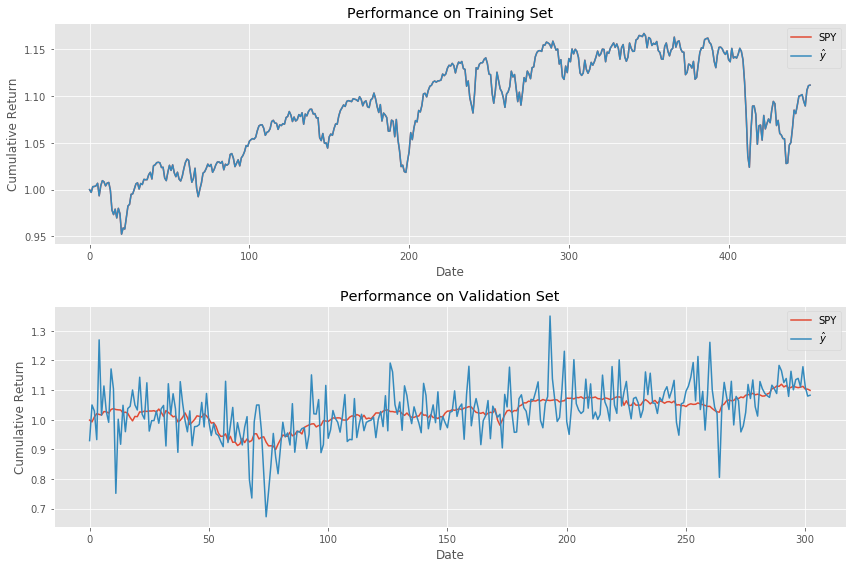

In [12]:
plt.figure(figsize=(12,8))

epsilon_train = (mu + Xtrain.dot(theta)) - ytrain
yhat_train = np.exp(ytrain.cumsum().reshape((-1, 1)) + epsilon_train)

epsilon_test = (mu + Xtest.dot(theta)) - ytest
yhat_test = np.exp(ytest.cumsum().reshape((-1, 1)) + epsilon_test)

plt.subplot(2,1,1)
plt.plot(np.exp(ytrain.cumsum()), label='SPY')
plt.plot(yhat_train, label=r'$\hat{y}$')
plt.title('Performance on Training Set')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.exp(ytest.cumsum()), label='SPY')
plt.plot(yhat_test, label=r'$\hat{y}$')
plt.title('Performance on Validation Set')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()

plt.show()

along with a histogram of the residual distribution

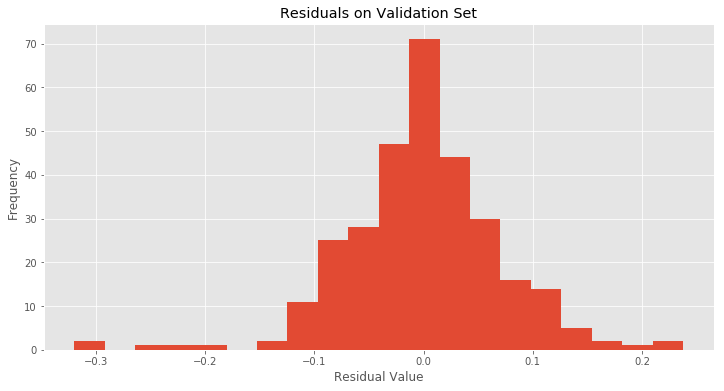

In [13]:
plt.figure(figsize=(12,6))

plt.hist(epsilon_test, 20)
plt.title('Residuals on Validation Set')
plt.ylabel('Frequency')
plt.xlabel('Residual Value')
plt.show()

We can see signs of gross overfitting on the training set. Furthermore, as expected, the residuals do not appear Gaussian. To verify this rigorously, we'll perform a Shapiro-Wilks test.

In [14]:
from scipy.stats import shapiro

print('p-value of test is %.9f.' % shapiro(epsilon_test)[1])

p-value of test is 0.000000321.


The p-value suggests we reject the null hypothesis of normality at the .01% level. The proposed method for computing prediction intervals assumes normality (for calculation of the quantiles from SD) and homoscedasticity, both of which do not seem to hold with financial data. Therefore, the method may not perform as expected.

### C. Adaptive Index Quantiles with Quantile Regression

Perform quantile regression on the training set to estimate the 1-step-ahead 90th percentile of the `SPY`. Use the setting `solver=CBC` when calling the `.solve()` method in `cvxpy` **if you can** (this is not a requirement, but will significantly speed up compute time). How does this model perform on the validation set? Plot the daily returns of `SPY` on the training and validation sets with the forcasted $90^{th}$ percentile superimposed.

Speculate about how this model would perform in practice compared to the least squares model in the previous part.

### SOLUTION.

We perform quantile regression on the training set

In [16]:
import cvxpy as cvx

ytrainp90 = np.percentile(ytrain, 90)

theta = cvx.Variable(p)
objective = cvx.Minimize(
    .9*cvx.sum_entries(
        cvx.pos(ytrain - ytrainp90 - Xtrain*theta)
    ) + .1*cvx.sum_entries(
        cvx.pos(Xtrain*theta + ytrainp90 - ytrain)
    )
)
cvx.Problem(objective).solve()

np.mean(ytest <= ytrainp90 + Xtest.dot(theta.value))

0.53795379537953791

It appears that, on the validation set, this model is a 54th percentile or so. Let's view performance on the training and validation sets. 

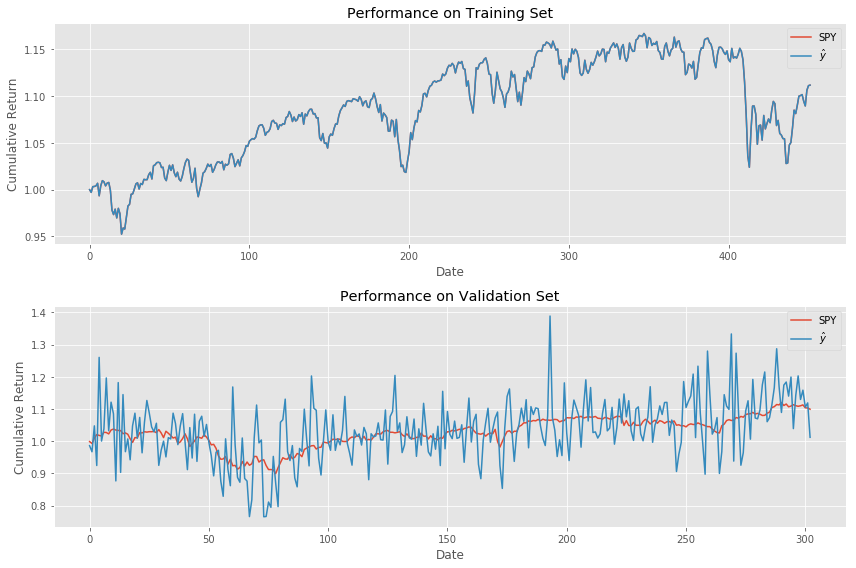

In [17]:
plt.figure(figsize=(12,8))

epsilon_train = (ytrainp90 + Xtrain.dot(theta.value)) - ytrain
yhat_train = np.exp(ytrain.cumsum().reshape((-1, 1)) + epsilon_train)

epsilon_test = (ytrainp90 + Xtest.dot(theta.value)) - ytest
yhat_test = np.exp(ytest.cumsum().reshape((-1, 1)) + epsilon_test)

plt.subplot(2,1,1)
plt.plot(np.exp(ytrain.cumsum()), label='SPY')
plt.plot(yhat_train, label=r'$\hat{y}$')
plt.title('Performance on Training Set')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.exp(ytest.cumsum()), label='SPY')
plt.plot(yhat_test, label=r'$\hat{y}$')
plt.title('Performance on Validation Set')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()

plt.show()

Since the quantile function is robust to outliers and other departures from the Gaussian assumption, this method for computing out-of-sample quantiles may be more successful in practice than the method mentioned in part B. However, without regularization to control overfitting, the model is too unstable for practical application.

### D. Adaptive Index Quantiles with Ridged Quantile Regression

Repeat the previous exercise, but with an $\ell_2$ penalty on the vector of regression coefficients $\theta$:

$$\theta_\lambda = \arg\min_{\theta} .9\cdot \mathbf{1}^\top\left(y_t - \alpha - X_{t-1}\theta\right)_+ + .1\cdot \mathbf{1}^\top\left(\alpha + X_{t-1}\theta - y_t\right)_+ + \lambda \|\theta\|_2^2$$

where $\mathbf{1}$ is the appropriately-sized vector with ones in all entries. Tune the $\ell_2$ penalty parameter $\lambda$ using the validation set to obtain the optimal penalty $\lambda^\star$. (Make sure to think about what defines the optimal model.)

How is the vector of regression coefficients $\theta_{\lambda^\star}$ different from $\theta_0$? How can you interpret this different coefficient weighting from an investing viewpoint? How does this model compare, on the validation set, to the model in the previous part? Finally, how do you think this model would compare to autoregressive volatility forecasting models such as GARCH? Explain.

### SOLUTION.

We start by performing cross-validation on the parameter $\lambda$, storing the $\lambda$ that leads to a model that is as close as possible to a 90th percentile model on the validation set.

In [ ]:
from math import inf
best_error = inf
best_lamb = None

for lamb in np.logspace(-1, 2, 20):

    objective = cvx.Minimize(
        .9*cvx.sum_entries(
            cvx.pos(ytrain - ytrainp90 - Xtrain*theta)
        ) + .1*cvx.sum_entries(
            cvx.pos(Xtrain*theta + ytrainp90 - ytrain)
        ) + lamb*cvx.sum_squares(theta)
    )

    cvx.Problem(objective).solve()
    
    epsilon = abs(.9 - np.mean(ytest <= ytrainp90 + Xtest.dot(theta.value)))
    
    if epsilon < best_error:
        best_lamb = lamb
        best_error = epsilon

# re-run best model

objective = cvx.Minimize(
    .9*cvx.sum_entries(
        cvx.pos(ytrain - ytrainp90 - Xtrain*theta)
    ) + .1*cvx.sum_entries(
        cvx.pos(Xtrain*theta + ytrainp90 - ytrain)
    ) + best_lamb*cvx.sum_squares(theta)
)

cvx.Problem(objective).solve()

best_error

It appears that this model does significantly better in fitting the 90th percentile than the unregularized model in the previous part. We next view the performance on the validation set time series.

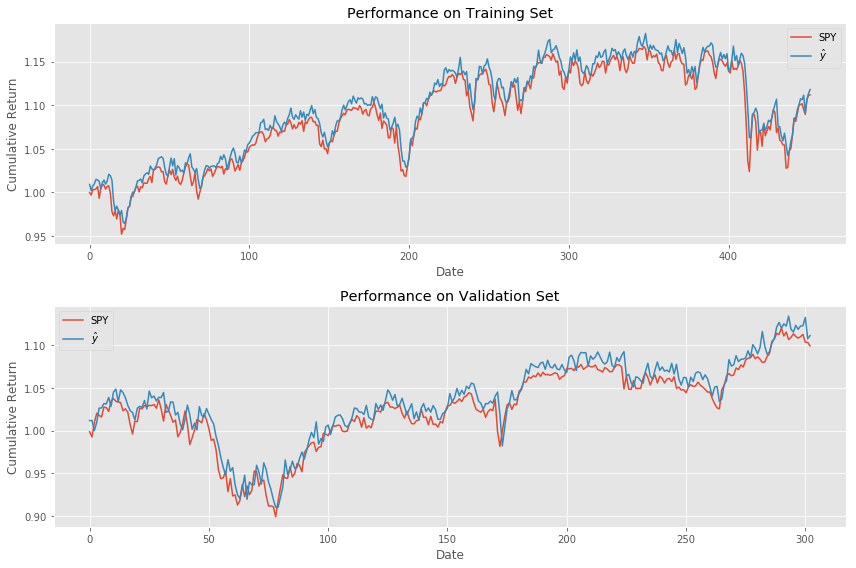

In [19]:
plt.figure(figsize=(12,8))

epsilon_train = (ytrainp90 + Xtrain.dot(theta.value)) - ytrain 
yhat_train = np.exp(ytrain.cumsum().reshape((-1, 1)) + epsilon_train)

epsilon_test = (ytrainp90 + Xtest.dot(theta.value)) - ytest
yhat_test = np.exp(ytest.cumsum().reshape((-1, 1)) + epsilon_test)

plt.subplot(2,1,1)
plt.plot(np.exp(ytrain.cumsum()), label='SPY')
plt.plot(yhat_train, label=r'$\hat{y}$')
plt.title('Performance on Training Set')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.exp(ytest.cumsum()), label='SPY')
plt.plot(yhat_test, label=r'$\hat{y}$')
plt.title('Performance on Validation Set')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()

plt.show()

By way of regularization, the coefficient vector appears to have a more even distribution of weights across the returns lags $X_{t-1}$. From an investing standpoint, this means diversifying our prediction by more evenly taking performance of all 500 constituent companies into account to say something about the next day's forecast.

# 3. Support Vector Machine

In this question, we consider an application of SVM in text classification for volatility prediction. Executing the following cell will load a $1470 \times 971$ `numpy` array into a variable `features` where each row corresponds to a published article and each column corresponds to the frequency of a keyword that appears in the article (i.e. our archive contains $1470$ articles and our dictionary contains $971$ keywords). Each article is about a certain company. Binary labels will also be imported as a $1470 \times 1$  `numpy` array `labels`. An article's label is $+1$ if the article caused an immediate and significant change (positive or negative) to the company's stock price. Otherwise, the label is $-1$. The data has been divided into a training set (`Xtrain` and `ytrain`), which will be used to train you SVM, and a validation set (`Xtest` and `ytest`) which will be used to test the SVM's prediction accuracy.

In [20]:
features = np.loadtxt('../../data/news/features.csv', delimiter=',') # load data here
labels = np.loadtxt('../../data/news/labels.csv', delimiter=',') # load data here

Xtrain = features[:-106]
ytrain = labels[:-106]

Xtest = features[-106:]
ytest = labels[-106:]

### A. $\ell_2$ SVM

The ridged-SVM classification problem can be formulated as the following optimization problem:

$$\underset{w, b}{\text{min }} \frac{1}{2}\left\|w\right\|_2^2 + C\sum_{i=1}^{1470}{\left(1 - y_i\left(w^\top x_i + b\right)\right)_+}$$

where $y_i$ denotes the $i^{th}$ label, $x_i$ denotes the $i^{th}$ vector of word frequencies in the articles, $w$ is the weights or vector of coefficients, $b$ is the offset or intercept, and $C$ is a model parameter is inversely related to the ridge regularization of the weights vector $w$. This is a quadratic optimization problem.

Using `cvxpy`, implement this SVM (estimate the $w$ and $b$ parameters) on the training set and tune the parameter $C$ from $0$ to $100$ by checking classification accuracy on the validation set. Plot the training accuracy versus $C$ curve and validation accuracy versus $C$ curve. Briefly comment on the results.

### SOLUTION.

_Your solution here._

### B. Feature Selection by Magnitude

We want to find the keywords that are most important for classification. Consider the following approach: Fix $C=10$ and perform SVM to estimate $w$ on the training set. Sort elements of $w$ by their absolute value in descending order, choose a the top $k$, and then perform SVM on this subset of the features. What are some advantages or disadvantages you anticipate in approaching feature selection in this manner?

Try $k\in \{10, 20, 30, \dots, 190, 200\}$ and evaluate classification accuracy on the validation set. Comment on the result.

### SOLUTION.

_Your solution here._

### C. $\ell_1$ SVM

Consider a different approach for feature selection: Subsitute the $\ell_2$-norm penalty with an $\ell_1$-norm penalty in the SVM objective:

$$\underset{w, b}{\text{min }} \left\|w\right\|_1 + C\sum_{i=1}^{1470}{\left(1 - y_i\left(w^\top x_i + b\right)\right)_+}$$

How might this approach compare to the previous feature-selection approach suggested in part B above?

Sweep the parameter $C$ in the interval $[0, 100]$ and plot the number of non-zero elements in $w$ versus the prameter $C$. Note that due to `cvxpy`'s limited numerical precision, zero elements are not exactly $0$. So the criterion for non-zero element is $|w_i| > 10^{-6}$. Perform a similar plot of validation set accuracy versus the parameter $C$. Comment on the results.

### SOLUTION.

_Your solution here._